<center><h1>Machine Learning on Graphs with Kernels<br>08/03/2022</h1>G. Nikolentzos, M. Vazirgiannis</center>

In this lab, we will focus on the problem of graph classification. Graph classification arises in the context of a number of classical domains such as chemical data, biological data, and the web. In order to perform graph classification, we will employ graph kernels, a powerful framework for graph comparison.

Kernels can be intuitively understood as functions measuring the similarity of pairs of objects. More formally, for a function $k(x,x')$ to be a kernel, it has to be ($1$) symmetric: $k(x,x') = k(x',x)$, and ($2$) positive semi-definite. If a function satisfies the above two conditions on a set $\mathcal{X}$, it is known that there exists a map $\phi : \mathcal{X} \to \mathcal{H}$ into a Hilbert space $\mathcal{H}$, such that $k(x,x') = \langle \phi(x), \phi(x') \rangle$ for all $(x, x') \in \mathcal{X}^2$ where $\langle\cdot, \cdot\rangle$ is the inner product in $\mathcal{H}$. Kernel functions thus compute the inner product between examples that are mapped in a higher-dimensional feature space. However, they do not necessarily explicitly compute the feature map $\phi$ for each example. One advantage of kernel methods is that they can operate on very general types of data such as images and graphs. Kernels defined on graphs are known as *graph kernels*. Most graph kernels decompose graphs into their substructures and then to measure their similarity, they count the number of common substructures.
Graph kernels typically focus on some structural aspect of graphs such as random walks, shortest paths, subtrees, cycles, and graphlets.

## Dataset Generation
We will first create a very simple graph classification dataset. The dataset will contain two types of graphs: ($1$) cycle graphs, and ($2$) path graphs. A cycle graph $C_n$ is a graph on $n$ nodes containing a single cycle through all nodes, while a path graph $P_n$ is a tree with two nodes of degree $1$, and all the remaining $n-2$ nodes of degree $2$. Each graph is assigned a class label: label $0$ if it is a cycle or label $1$ if it is a path. The Figure below illustrates such a dataset consisting of three cycle graphs and three path graphs.

<img src="figures/synthetic_graphs.png" width="600"/>

<u>Tasks</u>:
- Fill in the body of the `create_dataset()` function to generate the dataset as described above.
- Use the `cycle_graph()` and `path_graph()` functions of NetworkX to generate $100$ cycle graphs and $100$ path graphs of size $n=3,\ldots,102$, respectively.
- Store the $200$ graphs in a list and their class labels in another list.

In [1]:
import networkx as nx

In [2]:
help(nx.cycle_graph)

Help on function cycle_graph in module networkx.generators.classic:

cycle_graph(n, create_using=None)
    Returns the cycle graph $C_n$ of cyclically connected nodes.
    
    $C_n$ is a path with its two end-nodes connected.
    
    Parameters
    ----------
    n : int or iterable container of nodes
        If n is an integer, nodes are from `range(n)`.
        If n is a container of nodes, those nodes appear in the graph.
    create_using : NetworkX graph constructor, optional (default=nx.Graph)
       Graph type to create. If graph instance, then cleared before populated.
    
    Notes
    -----
    If create_using is directed, the direction is in increasing order.



In [3]:
str(3)

'3'

In [4]:
# Generate simple dataset
def create_dataset():
    Gs = list()
    y = list()

    for i in range(3,103):
        Gs.append(nx.cycle_graph(i))
        y.append(0)
        Gs.append(nx.path_graph(i))
        y.append(1)

    return Gs, y

Gs, y = create_dataset()

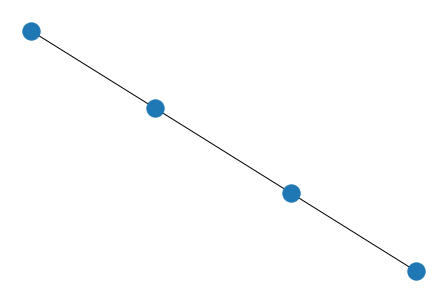

In [5]:
nx.draw(Gs[3])

Before computing the kernels, it is necessary to split the dataset into a training and a test set. We can use the `train_test_split()` function of scikit-learn.

<u>Task</u>:
- Use the `train_test_split()` function of scikit-learn to split the dataset into a training and a test set. Set the size of the test set equal to $10\%$ of the entire dataset.

In [6]:
from sklearn.model_selection import train_test_split

G_train, G_test, y_train, y_test = train_test_split(Gs,y,test_size= 0.1)

print('Size of training set',len(G_train))
print('Size of testing set',len(G_test))


Size of training set 180
Size of testing set 20


## Implementation of Graph Kernels

We will next investigate if graph kernels can distinguish cycle graphs from path graphs. We will use the following two graph kernels: ($1$) shortest path kernel, and ($2$) graphlet kernel.

The shortest path kernel counts the number of shortest paths of equal length in two graphs. It can be shown that in the case of unlabeled graphs, the kernel maps the graphs into a feature space where each feature corresponds to a shortest path distance and the value is equal to the frequency of that distance in the graph (see the following Figure for an illustration).

<img src="figures/sp.svg" width="350"/>

Once those feature vectors are generated, the shortest path kernel is defined as follows:

$$ k(G,G') = \langle \phi(G), \phi(G') \rangle $$

Given a set of training graphs (with cardinality $N_1$), a set of test graphs (with cardinality $N_2$) and a graph kernel, we are interested in generating two matrices. A symmetric matrix $\mathbf{K}_{train} \in \mathbb{R}^{N_1 \times N_1}$ which contains the kernel values for all pairs of training graphs, and a second matrix $\mathbf{K}_{test} \in \mathbb{R}^{N_2 \times N_1}$ which stores the kernel values between the graphs of the test set and those of the training set.

<u>Task</u>:
- Fill in the body of the `graphlet_kernel()` function. The function generates the feature maps of the equation above by counting the number of shortest paths of different lengths of each graph. Then, it generates the $\mathbf{K}_{train}$ and $\mathbf{K}_{test}$ matrices by computing the inner products between the feature maps.

In [11]:
import numpy as np

# Compute the shortest path kernel
def shortest_path_kernel(Gs_train, Gs_test):    
    all_paths = dict()
    sp_counts_train = dict()
    
    for i,G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()

        for n1 in nodes:
            for n2 in nodes:
                if n1!=n2:
                    length = sp_lengths[n1][n2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length]+=1
                    else:
                        sp_counts_train[i][length]=1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
        
      
                        
    sp_counts_test = dict()

    for i,G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        
        for n1 in nodes:
            for n2 in nodes:
                if n1!=n2:
                    length = sp_lengths[n1][n2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length]+=1
                    else:
                        sp_counts_test[i][length]=1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)
        

    phi_train = np.zeros((len(Gs_train),len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i,all_paths[length]] = sp_counts_train[i][length]

    phi_test = np.zeros((len(Gs_test),len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i,all_paths[length]] = sp_counts_test[i][length]
 

    
    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

The graphlet kernel decomposes graphs into graphlets (i.e., small subgraphs with $k$ nodes where $k \in \{ 3,4,5\}$) and counts matching graphlets in the input graphs. For example, the set of graphlets of size $3$ is shown in the following Figure.

<img src="figures/graphlets.svg" width="350"/>

The graphlet kernel samples a number of small subgraphs from a graph, and computes their distribution. Here, we will focus on graphlets of size $3$. Let $\{ \text{graphlet}_1, \text{graphlet}_2, \text{graphlet}_3,  \text{graphlet}_4 \}$ be the set of size-$3$ graphlets (i.e., those shown in the Figure above). The graphlet kernel uses the mapping $\phi : \mathcal{G} \rightarrow \mathbb{N}^4$ to project each graph into a vector whose $i$-th entry is equal to the number of sampled subgraphs from the graph that are isomorphic to $\text{graphlet}_i$. Then, the graphlet kernel is defined as follows:

$$ k(G,G') = \langle \phi(G), \phi(G') \rangle $$

We will next implement the graphlet kernel.

<u>Task</u>:
- Fill in the body of the `graphlet_kernel()` function. The function generates the feature maps of the equation above by sampling `n_samples` size-$3$ graphlets from each graph. Then, it generates the $\mathbf{K}_{train}$ and $\mathbf{K}_{test}$ matrices by computing the inner products between the feature maps (Hint: you can use the `random.choice()` function of NumPy to sample $3$ nodes from the set of nodes of a graph. Given a set of nodes `s`, use the `G.subgraph(s)` function of NetworkX to obtain the subgraph induced by set `s`. To test if a subgraph is isomorphic to a graphlet, use the `is_isomorphic()` function of NetworkX).

In [12]:
# Compute the graphlet kernel
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]
    
    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0,1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0,1)
    graphlets[2].add_edge(1,2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0,1)
    graphlets[3].add_edge(1,2)
    graphlets[3].add_edge(0,2)

    
    phi_train = np.zeros((len(G_train), 4))
    phi_test = np.zeros((len(G_test), 4))
    
    for i,G in enumerate(G_train):
        nodes = list(G.nodes())
        for _ in range(n_samples):
            subset = np.random.choice(nodes, size =3, replace = False)
            subG = G.subgraph(subset)
            for j in range(4):
                if nx.is_isomorphic(subG,graphlets[j]):
                    phi_train[i,j]+=1
                    break

    for i,G in enumerate(G_test):
        nodes = list(G.nodes())
        for _ in range(n_samples):
            subset = np.random.choice(nodes, size =3, replace = False)
            subG = G.subgraph(subset)
            for j in range(4):
                if nx.is_isomorphic(subG,graphlets[j]):
                    phi_test[i,j]+=1
                    break


    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

## Graph Classification using SVM

<u>Task</u>:
- Use the `shortest_path_kernel()` and `graphlet_kernel()` functions that you implemented to compute the kernel matrices associated with the two kernels.

In [14]:
K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)
K_train_gk, K_test_gk = graphlet_kernel(G_train, G_test)

After generating the $\mathbf{K}_{train}$ and $\mathbf{K}_{test}$ matrices, we can use the SVM classifier to perform graph classification. More specifically, as shown below, we can directly feed the kernel matrices to the classifier to perform training and make predictions:

```
from sklearn.svm import SVC

# Initialize SVM and train
clf = SVC(kernel='precomputed')
clf.fit(K_train, y_train)

# Predict
y_pred = clf.predict(K_test)
```

<u>Tasks</u>:
- Train two SVM classifiers (i.e., one using the kernel matrix generated by the shortest path kernel, and the other using the kernel matrix generated by the graphlet kernel).
- Then, use the two classifiers to make predictions.
- Evaluate the two kernels (i.e., shortest path and graphlet) by computing the classification accuracies of the corresponding models (Hint: use the `accuracy_score()` function of scikit-learn).

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf_sp = SVC(kernel='precomputed')
clf_sp.fit(K_train_sp,y_train)
y_pred_sp = clf_sp.predict(K_test_sp)
print('Accuracy of shortest path kernel:', accuracy_score(y_test,y_pred_sp))

clf_gk = SVC(kernel='precomputed')
clf_gk.fit(K_train_gk,y_train)
y_pred_gk = clf_gk.predict(K_test_gk)
print('Accuracy of graphlet kernel:', accuracy_score(y_test,y_pred_gk))


Accuracy of shortest path kernel: 0.95
Accuracy of graphlet kernel: 0.45
